In [1]:
import csv
import glob
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import spectral_embedding as se

### Load airport data

In [2]:
airport_lats = {}
airport_longs = {}
airport_continents = {}
first = True

with open('../../../Datasets/Flight Data/airports.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    
    for line in reader:
        if first:
            first = False
            continue
        
        airport = line[1]
        lat = line[4]
        long = line[5]
        continent = line[7]
    
        if continent not in ['NA','AS','EU','SA','OC','AF']:
            airport_continents[airport] = 'XX'
        else:
            airport_continents[airport] = continent
    
        airport_lats[airport] = float(lat)
        airport_longs[airport] = float(long)  

### Load network data

In [16]:
nodes = {}
count = 0

sources = [[] for i in range(36)]
targets = [[] for i in range(36)]
weights = [[] for i in range(36)]

years = [2019, 2020, 2021]

for y in range(3):
    year = years[y]
    
    for month in range(12):
        first = True
        t = 12*y + month 
        
        if month < 9:
            month_str = '0' + str(month+1)
        else:
            month_str = str(month+1)
    
        filename = glob.glob('../../../Datasets/Flight Data/flightlist_' + str(year) + month_str + '*.csv')[0]
        print(t, filename)
        file = open(filename, 'r')
    
        for line in file:
            if first:
                first = False
                continue
        
            data = line.strip('\n').split(',')
            source = data[4]
            target = data[5]
    
            # Ignore blank entries
            if source == '' or target == '':
                continue
        
            # Ignore self-connections
            if source == target:
                continue
        
            # Ignore XX continent flight sources
            if source not in airport_continents or airport_continents[source] == 'XX':
                continue
        
            # Ignore XX continent flight targets
            if target not in airport_continents or airport_continents[target] == 'XX':
                continue
            
            if source not in nodes:
                nodes[source] = count
                count += 1
            if target not in nodes:
                nodes[target] = count
                count += 1
        
            sources[t].append(nodes[source])
            targets[t].append(nodes[target])

0 ../../../Datasets/Flight Data/flightlist_20190101_20190131.csv
1 ../../../Datasets/Flight Data/flightlist_20190201_20190228.csv
2 ../../../Datasets/Flight Data/flightlist_20190301_20190331.csv
3 ../../../Datasets/Flight Data/flightlist_20190401_20190430.csv
4 ../../../Datasets/Flight Data/flightlist_20190501_20190531.csv
5 ../../../Datasets/Flight Data/flightlist_20190601_20190630.csv
6 ../../../Datasets/Flight Data/flightlist_20190701_20190731.csv
7 ../../../Datasets/Flight Data/flightlist_20190801_20190831.csv
8 ../../../Datasets/Flight Data/flightlist_20190901_20190930.csv
9 ../../../Datasets/Flight Data/flightlist_20191001_20191031.csv
10 ../../../Datasets/Flight Data/flightlist_20191101_20191130.csv
11 ../../../Datasets/Flight Data/flightlist_20191201_20191231.csv
12 ../../../Datasets/Flight Data/flightlist_20200101_20200131.csv
13 ../../../Datasets/Flight Data/flightlist_20200201_20200229.csv
14 ../../../Datasets/Flight Data/flightlist_20200301_20200331.csv
15 ../../../Datasets

In [17]:
n = len(nodes)
print('Number of nodes:', n)

Number of nodes: 17445


In [18]:
As = []

for t in range(36):
    m = len(sources[t])

    A = sparse.coo_matrix((np.ones(m), (sources[t], targets[t])), shape=(n,n))
    A = A + A.T
    As.append(A)

Set continent communities and assign colours.

In [19]:
Z = []
Z_col = []

for node in nodes:
    if node in airport_continents:
        continent = airport_continents[node]
    else:
        continent = 'XX'
        
    Z.append(continent)
    if continent == 'NA':
        Z_col.append('tab:red')
    elif continent == 'AS':
        Z_col.append('tab:blue')
    elif continent == 'EU':
        Z_col.append('tab:green')
    elif continent == 'SA':
        Z_col.append('tab:orange')
    elif continent == 'OC':
        Z_col.append('tab:purple')
    elif continent == 'AF':
        Z_col.append('tab:pink')
    else:
        Z_col.append('black')
        
Z = np.array(Z)
Z_col = np.array(Z_col)

In [20]:
continents = ['NA', 'AS', 'EU', 'SA', 'OC', 'AF']
continent_cols = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:pink']

In [21]:
fig = plt.figure()
handles = [plt.scatter([],[], color='tab:red', marker='o', s=8, label=r'North America'),
           plt.scatter([],[], color='tab:blue', marker='o', s=8, label=r'Asia'),
           plt.scatter([],[], color='tab:green', marker='o', s=8, label=r'Europe'),
           plt.scatter([],[], color='tab:orange', marker='o', s=8, label=r'South America'),
           plt.scatter([],[], color='tab:purple', marker='o', s=8, label=r'Oceania'),
           plt.scatter([],[], color='tab:pink', marker='o', s=8, label=r'Africa')]
plt.close()

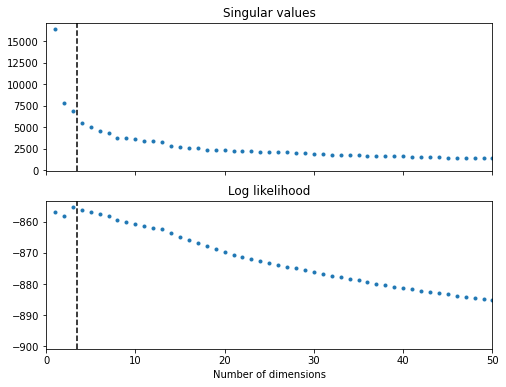

In [34]:
lq_best, lq, SA_wgt = se.dim_select(A, 100)
se.plot_dim_select(lq_best, lq, SA_wgt, max_plot=50)

In [35]:
d = 4
_, YAs = se.UASE(As, d)

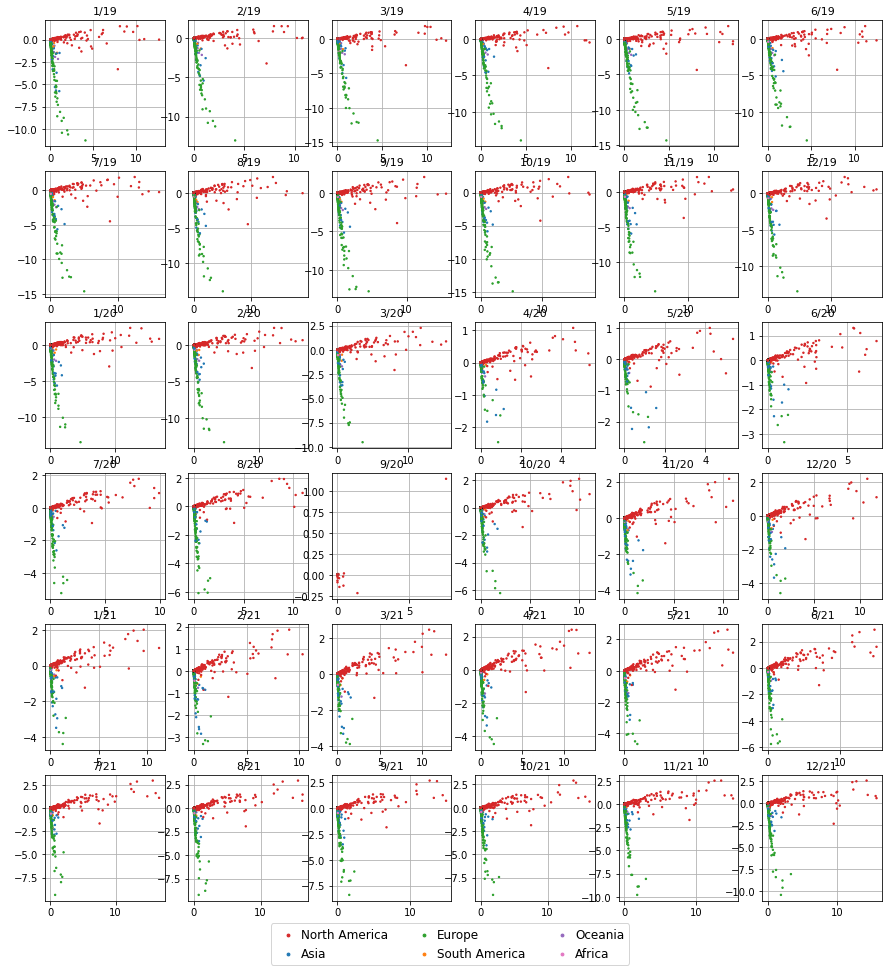

In [48]:
fig, axs = plt.subplots(6, 6, figsize=(2.5*6,2.5*6))

for t in range(36):
    axs[np.divmod(t,6)].grid(); axs[np.divmod(t,6)].set_axisbelow(True)
    axs[np.divmod(t,6)].scatter(YAs[t,:,0], YAs[t,:,1], marker='.', s=8, c=Z_col)
    axs[np.divmod(t,6)].set_title(str(t % 12 + 1) + '/' + str(years[int(t/12)] - 2000), fontsize=10)

fig.legend(handles=handles, bbox_to_anchor=(0.5,0), loc='lower center', ncol=3, fancybox=True, fontsize=12, handletextpad=0.1)
plt.subplots_adjust(bottom = 0.065);

In [37]:
def spherical_embed(x):
    d = len(x)
    theta = np.zeros(d-1)
    
    if x[0] > 0:
        theta[0] = np.arccos(x[1] / np.linalg.norm(x[:2]))
    else:
        theta[0] = 2*np.pi - np.arccos(x[1] / np.linalg.norm(x[:2]))
        
    for i in range(d-1):
        theta[i] = np.arccos(x[i+1] / np.linalg.norm(x[:(i+2)]))
        
    return theta

In [40]:
YDs = np.zeros((36,n,d-1))

for t in range(36):
    for i in range(n):
        if np.linalg.norm(YAs[t,i]) > 1e-12:
            YDs[t,i] = spherical_embed(YAs[t,i])

In [ ]:
fig, axs = plt.subplots(6, 6, figsize=(2.5*6,2.5*6))

for t in range(36):
    axs[np.divmod(t,6)].grid(); axs[np.divmod(t,6)].set_axisbelow(True)
    axs[np.divmod(t,6)].scatter(YDs[t,:,0], YDs[t,:,1], marker='.', s=8, c=Z_col)
    axs[np.divmod(t,6)].set_title(str(t % 12 + 1) + '/' + str(years[int(t/12)] - 2000), fontsize=10)

fig.legend(handles=handles, bbox_to_anchor=(0.5,0), loc='lower center', ncol=3, fancybox=True, fontsize=12, handletextpad=0.1)
plt.subplots_adjust(bottom = 0.065);